<img src="logo.png" alt="UMU logo" height="10px" width="200px"  style="display:block; margin-left:auto; margin-right:auto;">
<h2> UMU Data Analysis and Visualization </h2>
<h4> Hitanghu Moses Mulongo - 2024-M132-20791 </h4>
<h4>Open Test - R Version (Customer Churn) </h4>

<h2> Installing Packages </h2>

In [ ]:
#install.packages("tidyr")
#install.packages("dplyr")

<h2> Load Libraries </h2>

In [1]:
# Load libraries
library(ggplot2)
library(reshape2)
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
library(fastDummies)
suppressPackageStartupMessages(library(randomForest))
library(randomForest)
library(caret)       # for confusionMatrix, train, etc.
suppressPackageStartupMessages(library(pROC))

Loading required package: lattice



<h2> Load Dataset </h2>

In [3]:
# Load CSV file
customer_churn_df <- read.csv("Customer-Churn.csv",header = TRUE, sep = ",", stringsAsFactors = FALSE)
head(customer_churn_df)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,⋯,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
2,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,⋯,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,⋯,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,⋯,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
5,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
6,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,⋯,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


In [ ]:
colnames(customer_churn_df)

<h2> Summary Statics </h2>

In [6]:
summary(customer_churn_df)

  customerID           gender          SeniorCitizen      Partner         
 Length:7043        Length:7043        Min.   :0.0000   Length:7043       
 Class :character   Class :character   1st Qu.:0.0000   Class :character  
 Mode  :character   Mode  :character   Median :0.0000   Mode  :character  
                                       Mean   :0.1621                     
                                       3rd Qu.:0.0000                     
                                       Max.   :1.0000                     
                                                                          
  Dependents            tenure      PhoneService       MultipleLines     
 Length:7043        Min.   : 0.00   Length:7043        Length:7043       
 Class :character   1st Qu.: 9.00   Class :character   Class :character  
 Mode  :character   Median :29.00   Mode  :character   Mode  :character  
                    Mean   :32.37                                        
                    3rd Qu.:55

<h2>Bar Graph for Churn Distribution </h2>

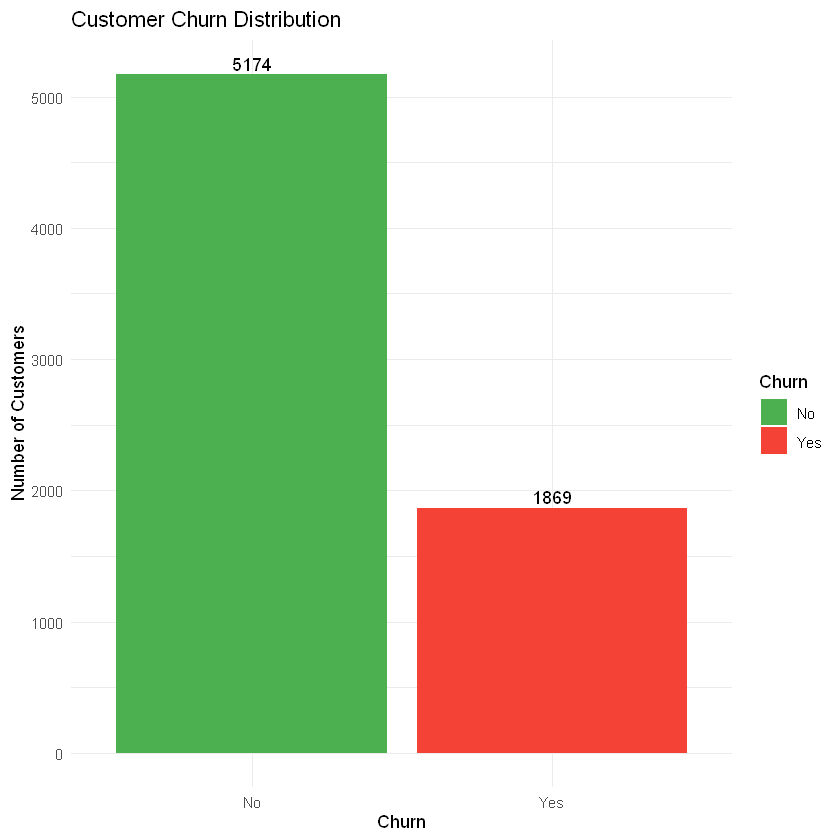

In [7]:
ggplot(customer_churn_df, aes(x = Churn, fill = Churn)) +
  geom_bar() +
  geom_text(stat = "count", aes(label = after_stat(count)), vjust = -0.3) +
  scale_fill_manual(values = c("No" = "#4CAF50", "Yes" = "#F44336")) +
  labs(title = "Customer Churn Distribution",
       x = "Churn",
       y = "Number of Customers") +
  theme_minimal()

<h2> Boxplots: churn vs non-churn for charges </h2>

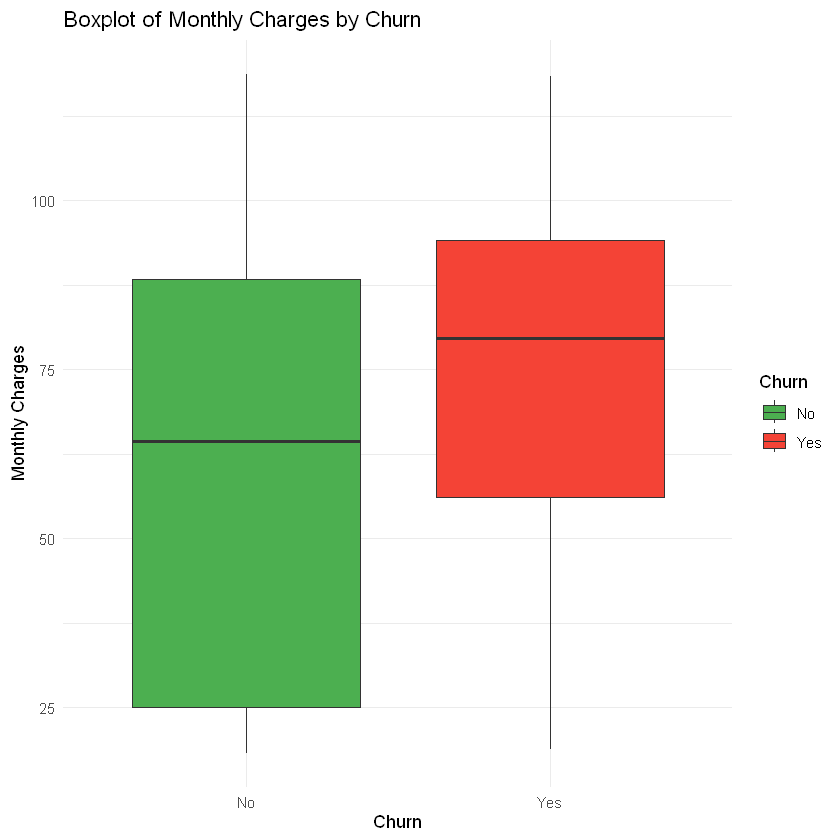

In [8]:
ggplot(customer_churn_df, aes(x = Churn, y = MonthlyCharges, fill = Churn)) +
  geom_boxplot() +
  scale_fill_manual(values = c("No" = "#4CAF50", "Yes" = "#F44336")) +
  labs(title = "Boxplot of Monthly Charges by Churn",
       x = "Churn",
       y = "Monthly Charges") +
  theme_minimal()

<p> -- According to this Box plot, there is no outliers in this dataframe --- </p>

<h2> Correlation heatmap for numerical features </h2>

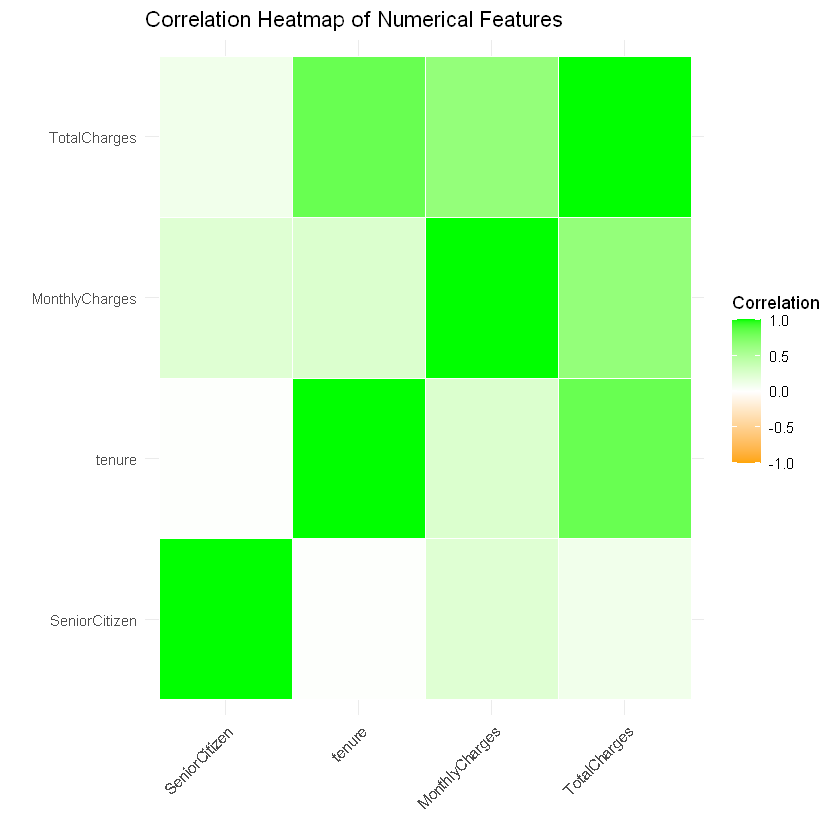

In [9]:

# Select only numeric columns
numeric_df <- customer_churn_df[, sapply(customer_churn_df, is.numeric)]

# Compute correlation matrix
cor_matrix <- cor(numeric_df, use = "complete.obs")

# Reshape correlation matrix for ggplot2
cor_data <- melt(cor_matrix)

# Plot heatmap
ggplot(cor_data, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "orange", high = "green", mid = "white", 
                       midpoint = 0, limit = c(-1, 1), space = "Lab",
                       name = "Correlation") +
  theme_minimal() +
  labs(title = "Correlation Heatmap of Numerical Features",
       x = "",
       y = "") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

<h2> 2.0 Peprocessing </h2>

<h4> 2.1 Handle missing data </h4>

In [4]:
# fucnction to check missing values
check_missing_values <- function(){
missing_table <- data.frame(

  missing_values = colSums(is.na(customer_churn_df))
)

missing_table
    }
check_missing_values()

,missing_values
,<dbl>
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0


<p> --- We have some missing values in Total Charges --- </p>

<h4> 2.1.1 Replace Misising Values with mean </h4>

In [6]:
# Replace NA values in TotalCharges with column mean
customer_churn_df$TotalCharges[is.na(customer_churn_df$TotalCharges)] <- 
  mean(customer_churn_df$TotalCharges, na.rm = TRUE)


<h4> 2.1.2 Check for missing values again </h4>

In [8]:
check_missing_values()#function to check miissing values

,missing_values
,<dbl>
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0


<p> --- All missing values have been imputed with mean --- </p>

<h2>2.2 Encode categorical variables (One-Hot) </h2>
<p> Before appling One Hot encoding, let us create tenure groups.</p>

In [10]:
# Replace numeric tenure with categorical groups
customer_churn_df$tenure <- cut(
  customer_churn_df$tenure,
  breaks = c(-Inf, 12, 48, Inf),
  labels = c("Short", "Medium", "Long")
)

# Check result
table(customer_churn_df$tenure)


 Short Medium   Long 
  2186   2618   2239 

<h2> 2.1 Encoding Categorical Columns </h2>

In [12]:

# List of categorical columns you want to encode
categorical_cols <- c("gender", "Partner", "Dependents", "PhoneService", 
                      "MultipleLines", "InternetService", "OnlineSecurity", 
                      "OnlineBackup", "DeviceProtection", "TechSupport", 
                      "StreamingTV", "StreamingMovies", "Contract", 
                      "PaperlessBilling", "PaymentMethod")

# One-hot encode all at once
customer_churn_df <- dummy_cols(customer_churn_df, 
                                select_columns = categorical_cols,
                                remove_first_dummy = TRUE,   # optional: avoid dummy variable trap
                                remove_selected_columns = FALSE)  # optional: remove original columns

# Check the first few rows
head(customer_churn_df)



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,⋯,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
,<chr>,<chr>,<int>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,7590-VHVEG,Female,0,Yes,No,Short,No,No phone service,DSL,No,⋯,0,0,0,0,0,0,1,0,1,0
2,5575-GNVDE,Male,0,No,No,Medium,Yes,No,DSL,Yes,⋯,0,0,0,0,1,0,0,0,0,1
3,3668-QPYBK,Male,0,No,No,Short,Yes,No,DSL,Yes,⋯,0,0,0,0,0,0,1,0,0,1
4,7795-CFOCW,Male,0,No,No,Medium,No,No phone service,DSL,Yes,⋯,0,0,0,0,1,0,0,0,0,0
5,9237-HQITU,Female,0,No,No,Short,Yes,No,Fiber optic,No,⋯,0,0,0,0,0,0,1,0,1,0
6,9305-CDSKC,Female,0,No,No,Short,Yes,Yes,Fiber optic,No,⋯,0,1,0,1,0,0,1,0,1,0


<h2> 3.0 Feature Engineering & Reduction </h2>

<h2>3.1 Total monthly charges per contract type</h2>


In [14]:
library(dplyr)

total_charges_by_contract <- customer_churn_df %>%
  group_by(Contract) %>%
  summarise(TotalMonthlyCharges = sum(MonthlyCharges, na.rm = TRUE)) %>%
  arrange(desc(TotalMonthlyCharges))

total_charges_by_contract


Contract,TotalMonthlyCharges
<chr>,<dbl>
Month-to-month,257294.1
Two year,103005.9
One year,95816.6


<h4> Total Monthly Charges per Contract Type </h4>

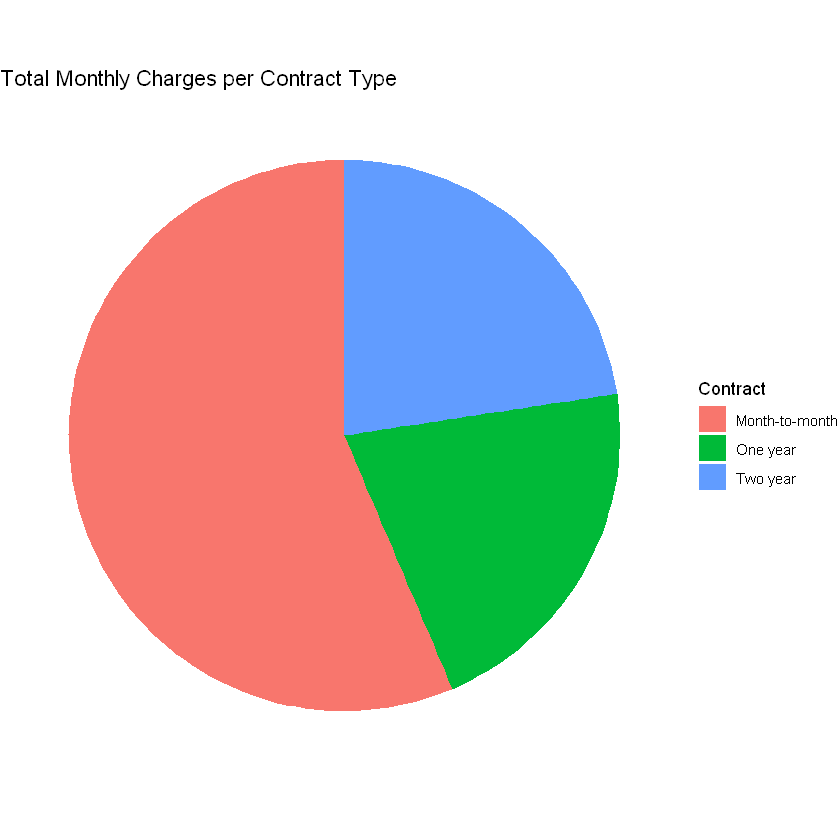

In [18]:
ggplot(total_charges_by_contract, aes(x = "", y = TotalMonthlyCharges, fill = Contract)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  labs(title = "Total Monthly Charges per Contract Type") +
  theme_void() +
  theme(legend.position = "right")

<h4> set predictiors as X and target as y </h4>

In [14]:
# 1. Identify dummy columns created by fastDummies (they contain "_")
dummy_cols <- names(customer_churn_df)[grepl("_", names(customer_churn_df))]

# 2. Identify numeric columns
numeric_cols <- names(customer_churn_df)[sapply(customer_churn_df, is.numeric)]

# 3. Exclude the target variable from numeric columns (assuming Churn is 0/1 now)
numeric_cols <- setdiff(numeric_cols, "Churn")

# 4. Combine feature columns
feature_cols <- c(dummy_cols, numeric_cols)

# 5. Create feature matrix X
X <- customer_churn_df[, feature_cols]

# 6. Target variable y
y <- customer_churn_df$Churn

# Check dimensions
dim(X)
head(X)


[1] 7043   55

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,⋯,StreamingTV_No internet service.1,StreamingTV_Yes.1,StreamingMovies_No internet service.1,StreamingMovies_Yes.1,Contract_One year.1,Contract_Two year.1,PaperlessBilling_Yes.1,PaymentMethod_Credit card (automatic).1,PaymentMethod_Electronic check.1,PaymentMethod_Mailed check.1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,1,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,1,0
2,1,0,0,1,0,0,0,0,0,1,⋯,0,0,0,0,1,0,0,0,0,1
3,1,0,0,1,0,0,0,0,0,1,⋯,0,0,0,0,0,0,1,0,0,1
4,1,0,0,0,1,0,0,0,0,1,⋯,0,0,0,0,1,0,0,0,0,0
5,0,0,0,1,0,0,1,0,0,0,⋯,0,0,0,0,0,0,1,0,1,0
6,0,0,0,1,0,1,1,0,0,0,⋯,0,1,0,1,0,0,1,0,1,0


<h4> Split data for training and testing dataset </h4>

In [16]:
library(caTools)

set.seed(123)  # for reproducibility

# Create split index (80% train, 20% test)
split <- sample.split(y, SplitRatio = 0.8)

# Training set
X_train <- subset(X, split == TRUE)
y_train <- subset(y, split == TRUE)

# Testing set
X_test <- subset(X, split == FALSE)
y_test <- subset(y, split == FALSE)

# Check dimensions
dim(X_train)
dim(X_test)


[1] 5634   55

[1] 1409   55

<h4> Normalizing data for training </h4>

In [18]:
numeric_cols <- names(X_train)[sapply(X_train, is.numeric)]

# Scale training data
train_means <- sapply(X_train[, numeric_cols], mean, na.rm = TRUE)
train_sds   <- sapply(X_train[, numeric_cols], sd, na.rm = TRUE)

X_train[, numeric_cols] <- scale(X_train[, numeric_cols],
                                 center = train_means,
                                 scale = train_sds)

# Apply same scaling to test data
X_test[, numeric_cols] <- scale(X_test[, numeric_cols],
                                center = train_means,
                                scale = train_sds)


<h4> Apply PCA </h4>

In [28]:
# Apply PCA on training data
pca_model <- prcomp(X_train, center = FALSE, scale. = FALSE)

# Check summary to see variance explained
#summary(pca_model)


In [30]:
# Decide number of PCs to keep (e.g., enough to explain 95% variance)
cum_var <- cumsum(pca_model$sdev^2 / sum(pca_model$sdev^2))
num_pc <- which(cum_var >= 0.95)[1] 

# Transform training and test data
X_train_pca <- as.data.frame(pca_model$x[, 1:num_pc])
X_test_pca  <- as.data.frame(predict(pca_model, newdata = X_test)[, 1:num_pc])

dim(X_train_pca)
dim(X_test_pca)


[1] 5634   17

[1] 1409   17

<h4> PCA explained variance chart </h4>

In [34]:
# Compute proportion of variance explained
pca_var <- pca_model$sdev^2
pca_var_prop <- pca_var / sum(pca_var)

# Create data frame for plotting
pca_df <- data.frame(
  PC = 1:length(pca_var_prop),
  Variance = pca_var_prop,
  CumulativeVariance = cumsum(pca_var_prop)
)
head(pca_df)

,PC,Variance,CumulativeVariance
,<int>,<dbl>,<dbl>
1,1,0.34116688,0.3411669
2,2,0.09788972,0.4390566
3,3,0.09545496,0.5345116
4,4,0.04887647,0.5833880
5,5,0.04496777,0.6283558
6,6,0.04463307,0.6729889


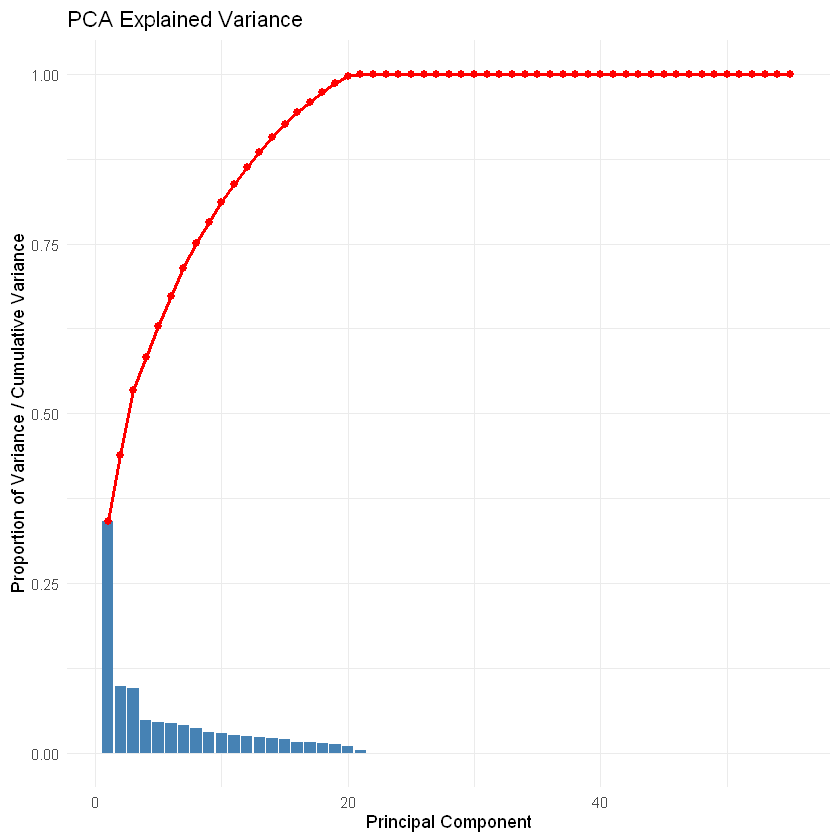

In [38]:

# Plot proportion of variance and cumulative variance

ggplot(pca_df, aes(x = PC, y = Variance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_line(aes(y = CumulativeVariance), color = "red", linewidth = 1) +
  geom_point(aes(y = CumulativeVariance), color = "red", size = 2) +
  labs(title = "PCA Explained Variance",
       x = "Principal Component",
       y = "Proportion of Variance / Cumulative Variance") +
  theme_minimal()



<p><b>Interpretation</b></p>

- PC1 alone explains ~35% of the total variance.

- The first ~5–10 PCs explain the majority (say ~80–95%) of the variance.

- Beyond ~15 PCs, the curve flattens — meaning additional components add very little information (only noise-like variance).

<h1> ML Model Training </h1>

<h4> 5.1 Random Forest </h4>

In [12]:
# Convert target to factor
y_train <- as.factor(y_train)
y_test  <- as.factor(y_test)

# Check
class(y_train)  # should now be "factor"

[1] "factor"

In [13]:


set.seed(123)
rf_model <- randomForest(x = X_train, 
                         y = y_train,
                         ntree = 500,
                         importance = TRUE)

print("\nRandom Forest model created successfully")

[1] "\nRandom Forest model created successfully"


<h4> Extract Feature Importance </h4>







In [33]:
# Get importance (MeanDecreaseGini is common for classification)
importance_values <- importance(rf_model)[, "MeanDecreaseGini"]

# Put into dataframe
importance_df <- data.frame(
  Feature = names(importance_values),
  Importance = importance_values,
  row.names = NULL
)

head(importance_df)


,Feature,Importance
,<chr>,<dbl>
1,gender_Male,26.903035
2,Partner_Yes,23.828473
3,Dependents_Yes,20.376687
4,PhoneService_Yes,4.771049
5,MultipleLines_No phone service,4.682497
6,MultipleLines_Yes,20.818107


<p> --- These feature importance are for the feature generated by one hot encoding therefore we will aggregate them back to the original features. --- </p>

<h4> Aggregate importance to original categorical variables </h4>

In [39]:
# Map dummy columns back to original feature
importance_df$BaseFeature <- sub("_.*", "", importance_df$Feature)

# Aggregate importance by original feature
agg_importance <- aggregate(Importance ~ BaseFeature, 
                            data = importance_df, sum)

# Sort descending
agg_importance <- agg_importance[order(-agg_importance$Importance), ]

# Reset row names
row.names(agg_importance) <- NULL

# Add rank column
agg_importance$Rank <- seq_len(nrow(agg_importance))

# Move Rank column to be first
agg_importance <- agg_importance[, c("Rank", "BaseFeature", "Importance")]

# Display
agg_importance


Rank,BaseFeature,Importance
<int>,<chr>,<dbl>
1,TotalCharges,310.813651
2,MonthlyCharges,194.170503
3,Contract,161.989909
4,PaymentMethod,152.978651
5,InternetService,120.764691
6,OnlineSecurity,75.087899
7,TechSupport,70.805285
8,OnlineBackup,59.773283
9,gender,54.907800


<h4> Visualize </h4>

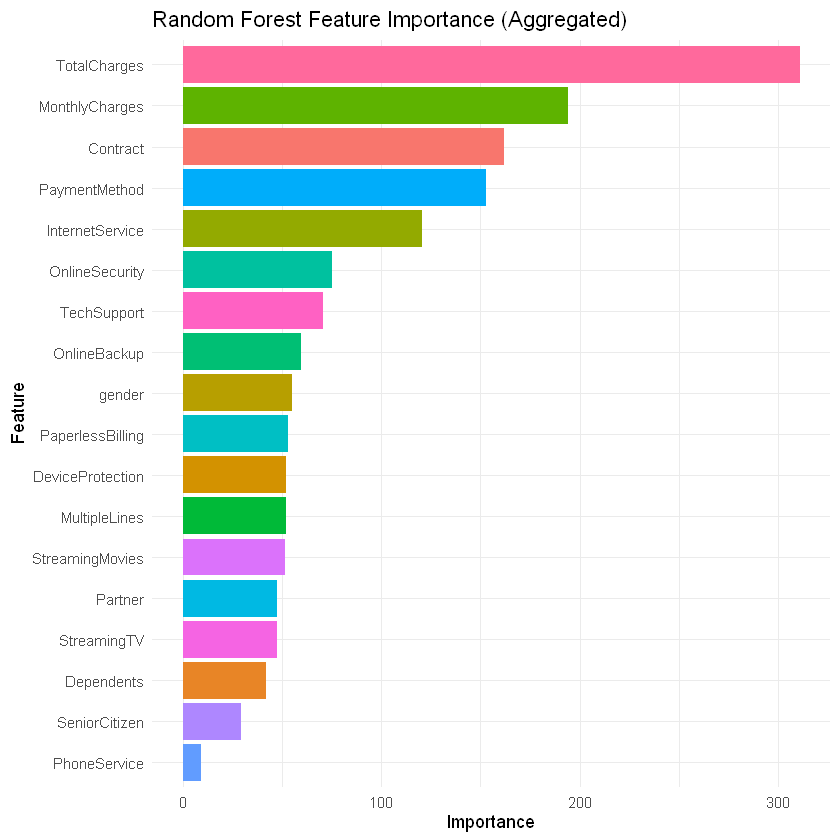

In [44]:
ggplot(agg_importance, aes(x = reorder(BaseFeature, Importance), 
                           y = Importance, fill = BaseFeature)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Random Forest Feature Importance (Aggregated)",
       x = "Feature",
       y = "Importance") +
  theme_minimal() +
  theme(legend.position = "none")



<h4> Random Forest Model Evaluation </h4>

In [15]:
# Predictions on test set
rf_pred <- predict(rf_model, X_test)
print('Finished predicting')

[1] "Finished predicting"


<h4> Confusion Matrix </h4>

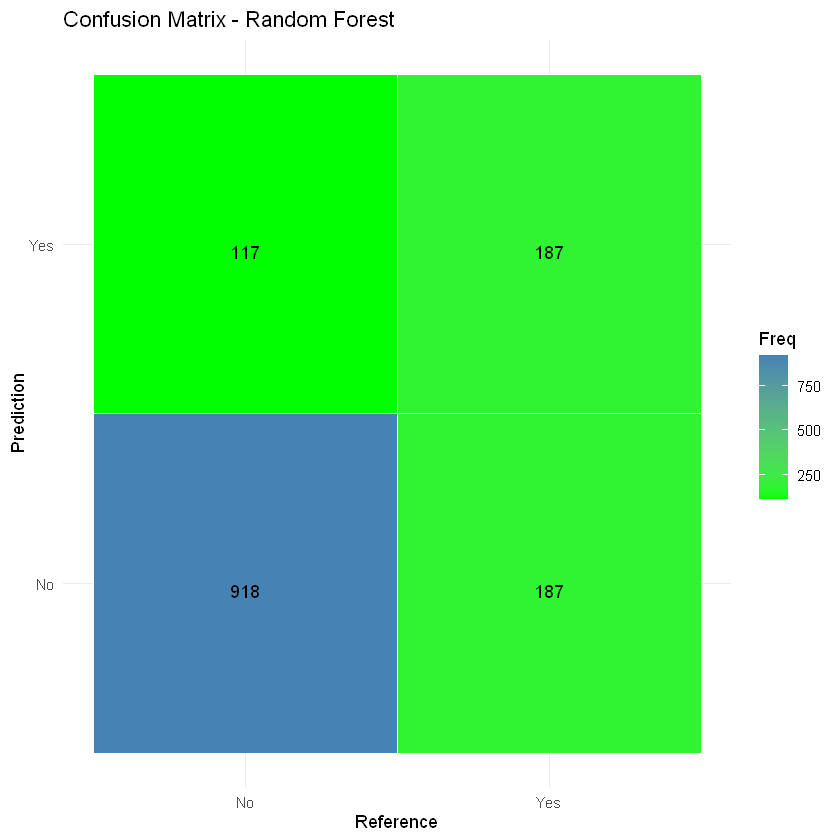

In [20]:
library(ggplot2)
library(caret)
library(reshape2)

# Confusion matrix object
cm <- confusionMatrix(rf_pred, as.factor(y_test), positive = "Yes")  # replace "Yes" with your positive class

# Convert to data frame for ggplot
cm_table <- as.data.frame(cm$table)
colnames(cm_table) <- c("Prediction", "Reference", "Freq")

# Plot
ggplot(cm_table, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Freq), vjust = 1) +
  scale_fill_gradient(low = "green", high = "steelblue") +
  labs(title = "Confusion Matrix - Random Forest") +
  theme_minimal()


<h4> Accuracy & Recall </h4>

In [21]:

# Extract metrics
accuracy <- cm$overall["Accuracy"]
recall <- cm$byClass["Recall"]

accuracy
recall

Accuracy 
0.7842441

Recall 
   0.5

<h4> ROC-AUC </h4>

Setting levels: control = No, case = Yes

Setting direction: controls < cases



Area under the curve: 0.8222

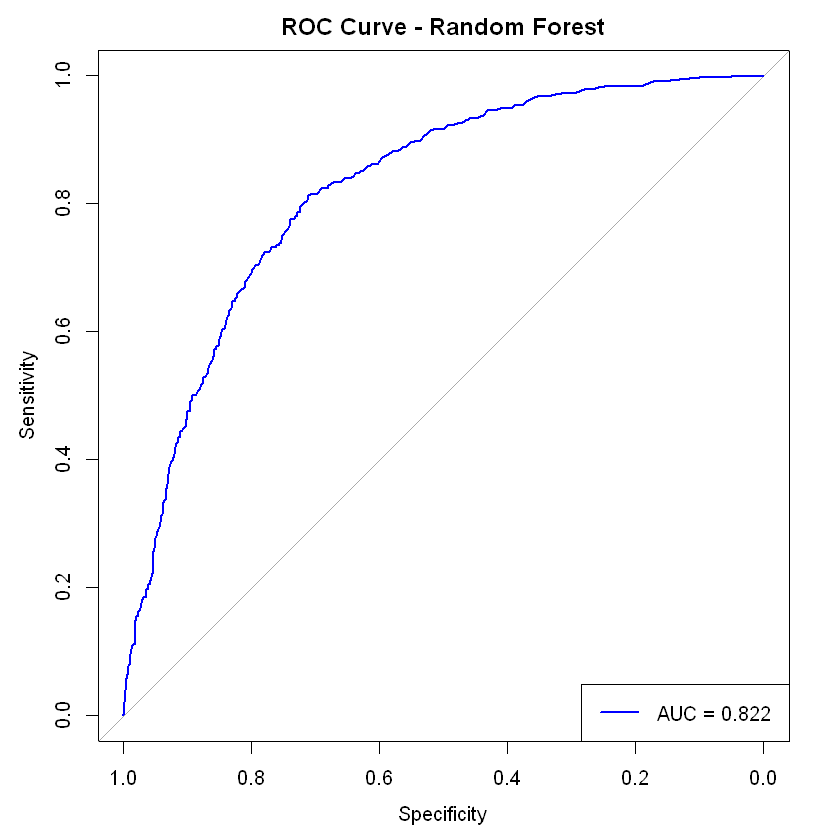

In [22]:
# Get predicted probabilities
rf_prob <- predict(rf_model, X_test, type = "prob")[,2]

# ROC Curve
roc_obj <- roc(as.factor(y_test), rf_prob)
auc_value <- auc(roc_obj)

plot(roc_obj, col = "blue", lwd = 2, main = "ROC Curve - Random Forest")
legend("bottomright", legend = paste("AUC =", round(auc_value, 3)), col = "blue", lwd = 2)

auc_value


<h4> Stratified k-Fold Cross Validation </h4>

In [23]:
set.seed(123)

ctrl <- trainControl(method = "cv", 
                     number = 5, 
                     classProbs = TRUE, 
                     summaryFunction = twoClassSummary)

cv_model <- train(x = X_train, y = as.factor(y_train),
                  method = "rf",
                  trControl = ctrl,
                  metric = "ROC")

cv_model


Random Forest 

5634 samples
  55 predictor
   2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4507, 4507, 4507, 4508, 4507 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   2    0.8257284  0.9649691  0.2602007
  28    0.8234599  0.8878947  0.5090301
  55    0.8229706  0.8864442  0.5177258

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

<h4> Make predictions with the best model from crossvalidation </h4>

In [25]:
# Predict classes for the test set
pred_classes <- predict(cv_model, newdata = X_test)


In [37]:
# Predict probabilities for the positive class
pred_probs <- predict(cv_model, newdata = X_test, type = "prob")
pred_probs <- as.numeric(pred_probs[, "Yes"])

In [29]:
#Confusion matrix
confusionMatrix(pred_classes, as.factor(y_test))

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  997 304
       Yes  38  70
                                         
               Accuracy : 0.7573         
                 95% CI : (0.734, 0.7795)
    No Information Rate : 0.7346         
    P-Value [Acc > NIR] : 0.02785        
                                         
                  Kappa : 0.1947         
                                         
 Mcnemar's Test P-Value : < 2e-16        
                                         
            Sensitivity : 0.9633         
            Specificity : 0.1872         
         Pos Pred Value : 0.7663         
         Neg Pred Value : 0.6481         
             Prevalence : 0.7346         
         Detection Rate : 0.7076         
   Detection Prevalence : 0.9233         
      Balanced Accuracy : 0.5752         
                                         
       'Positive' Class : No             
                                         

<h4> Evaluation Metrics </h4>

In [38]:
# Accuracy
acc <- mean(pred_classes == y_test)
print(paste("Accuracy:", round(acc, 4)))

# Recall (Sensitivity)
cm <- confusionMatrix(pred_classes, as.factor(y_test))
recall <- cm$byClass["Sensitivity"]
print(paste("Recall:", round(recall, 4)))

# ROC-AUC
roc_obj <- roc(as.factor(y_test), pred_probs, levels = rev(levels(as.factor(y_test))))
auc_value <- auc(roc_obj)
print(paste("ROC-AUC:", round(auc_value, 4)))

[1] "Accuracy: 0.7573"
[1] "Recall: 0.9633"


Setting direction: controls > cases



[1] "ROC-AUC: 0.8099"


<p> *** crossvalidation slightl decreased accuracy and ROC-AUC but recall increased from 50% to 96% which is a good thing for our model ***</p>

<h2> Decision Tree Training </h2>

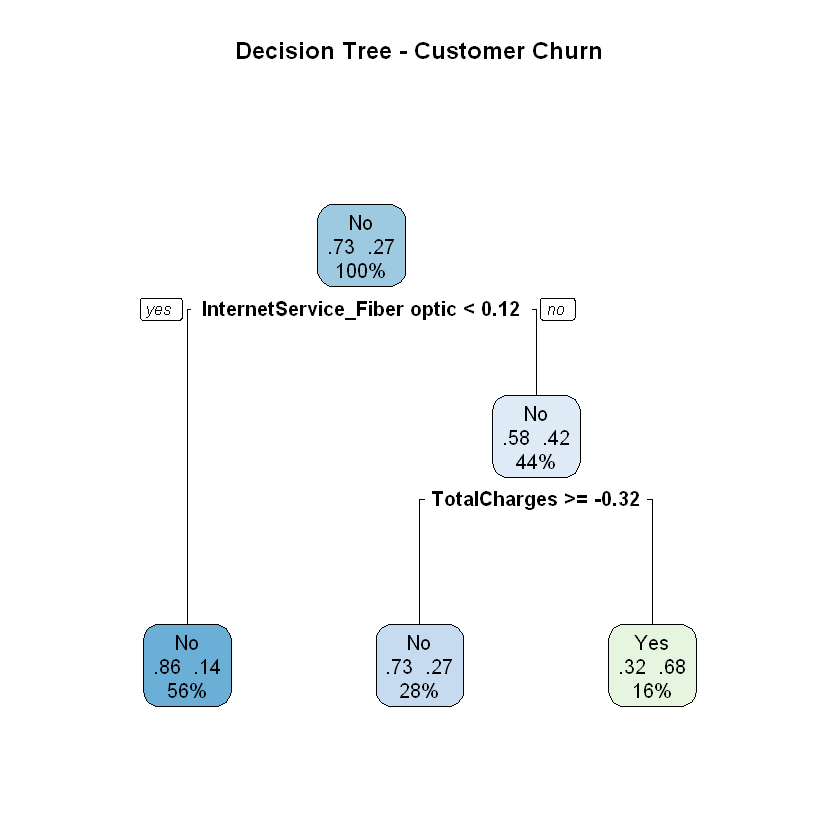

In [76]:
library(rpart)
library(rpart.plot)

# Train decision tree
dt_model <- rpart(y_train ~ ., data = X_train, method = "class")

# Print summary
#printcp(dt_model)   # complexity parameter table
#summary(dt_model)

# Visualize the decision tree
rpart.plot(dt_model, type = 2, extra = 104, fallen.leaves = TRUE,
           main = "Decision Tree - Customer Churn")


<h4>Predictions & Confusion Matrix</h4>

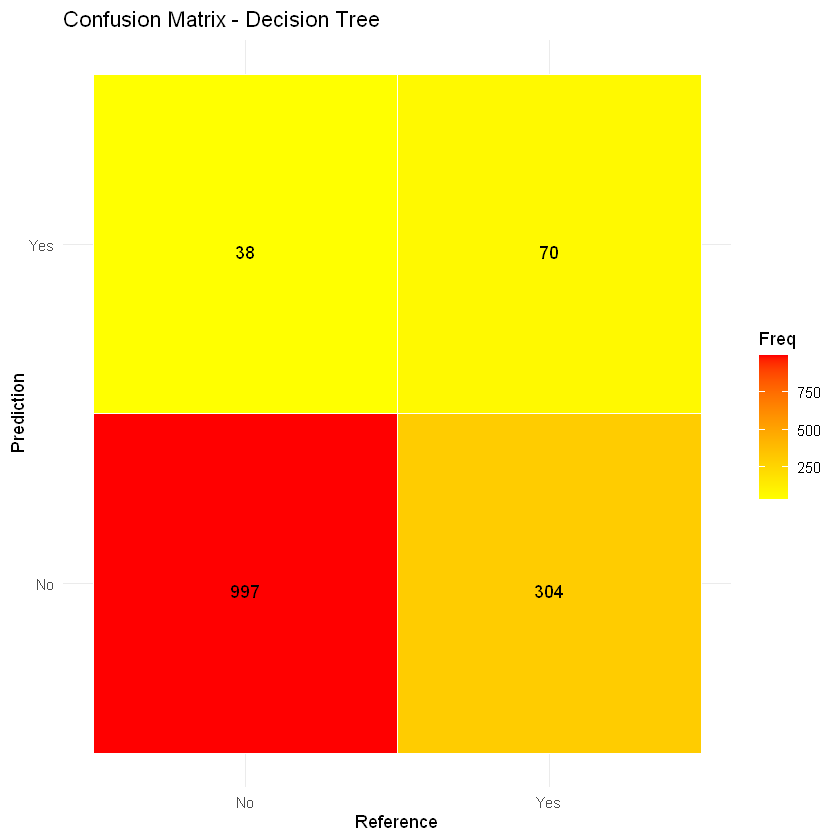

In [73]:
# Predict on test set
dt_pred <- predict(dt_model, newdata = X_test, type = "class")

# Confusion matrix
cm_dt <- confusionMatrix(dt_pred, as.factor(y_test), positive = "Yes") 
#print(cm_dt)
# Convert to data frame for ggplot
cm_table <- as.data.frame(cm$table)
colnames(cm_table) <- c("Prediction", "Reference", "Freq")

# Plot
ggplot(cm_table, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Freq), vjust = 1) +
  scale_fill_gradient(low = "yellow", high = "red") +
  labs(title = "Confusion Matrix - Decision Tree") +
  theme_minimal()


<h4> Feature Importance </h4>

In [55]:
# Variable importance
# Variable importance
dt_importance <- dt_model$variable.importance

# Convert to data frame
dt_importance_df <- data.frame(
  Feature = names(dt_importance),
  Importance = as.numeric(dt_importance)
)

# Sort in descending order
dt_importance_df <- dt_importance_df[order(-dt_importance_df$Importance), ]

# Display
dt_importance_df



,Feature,Importance
,<chr>,<dbl>
1,MonthlyCharges,242.09795
2,InternetService_Fiber optic,221.27750
3,InternetService_Fiber optic.1,221.27750
4,TotalCharges,189.09132
5,MultipleLines_Yes,91.77834
6,MultipleLines_Yes.1,91.77834
7,StreamingTV_Yes,59.33449
8,StreamingMovies_Yes,17.11514
9,StreamingMovies_Yes.1,17.11514


<h4> Aggregate feature importance to original features </h4>

In [59]:
# Variable importance from decision tree
dt_importance <- dt_model$variable.importance

# Convert to data frame
dt_importance_df <- data.frame(
  Feature = names(dt_importance),
  Importance = as.numeric(dt_importance),
  stringsAsFactors = FALSE
)

# Extract base feature name (everything before "_")
dt_importance_df$BaseFeature <- sub("_.*", "", dt_importance_df$Feature)

# Aggregate importance by base feature
agg_importance_dt <- aggregate(Importance ~ BaseFeature, 
                               data = dt_importance_df, 
                               sum)

# Sort descending
agg_importance_dt <- agg_importance_dt[order(-agg_importance_dt$Importance), ]

# Add rank
agg_importance_dt$Rank <- seq_len(nrow(agg_importance_dt))

# Reorder columns (Rank first)
agg_importance_dt <- agg_importance_dt[, c("Rank", "BaseFeature", "Importance")]

# Display
agg_importance_dt


,Rank,BaseFeature,Importance
,<int>,<chr>,<dbl>
1,1,InternetService,442.55500
2,2,MonthlyCharges,242.09795
6,3,TotalCharges,189.09132
3,4,MultipleLines,183.55668
5,5,StreamingTV,59.33449
4,6,StreamingMovies,34.23027


<h4> Extract Accuracy, Recall and ROC-AUC </h4>

In [62]:
library(caret)
library(pROC)


# Accuracy
accuracy <- cm_dt$overall["Accuracy"]

# Recall (Sensitivity in caret's output)
recall <- cm_dt$byClass["Sensitivity"]

# Get predicted probabilities for ROC
dt_prob <- predict(dt_model, newdata = X_test, type = "prob")[, "Yes"]

# ROC-AUC
roc_dt <- roc(as.factor(y_test), dt_prob)
auc_value <- auc(roc_dt)

# Print metrics
print(paste("Accuracy:", round(accuracy, 4)))
print(paste("Recall:", round(recall, 4)))
print(paste("ROC-AUC:", round(auc_value, 4)))


Setting levels: control = No, case = Yes

Setting direction: controls < cases



[1] "Accuracy: 0.7814"
[1] "Recall: 0.3877"
[1] "ROC-AUC: 0.6959"


<p> *** Accuracy is fair but Recall and ROC-AUC are very low *** </p>
<b>Let us apply crossvalidation to see whether it will improve the model performance.</b>

In [77]:
library(caret)
library(pROC)
library(rpart)

# Combine X_train and y_train into one dataframe
train_data <- data.frame(X_train, Churn = as.factor(y_train))

# Define stratified 5-fold CV
train_control <- trainControl(
  method = "cv",          # cross-validation
  number = 5,             # number of folds
  classProbs = TRUE,      # needed for ROC
  summaryFunction = twoClassSummary, # compute ROC, Sensitivity, Specificity
  savePredictions = "final"
)

# Train decision tree with CV
dt_cv <- train(
  Churn ~ ., 
  data = train_data, 
  method = "rpart",
  trControl = train_control,
  metric = "ROC"  # optimize based on ROC-AUC
)


# Extract predictions across folds
cv_preds <- dt_cv$pred

# Evaluation metrics
accuracy <- mean(cv_preds$pred == cv_preds$obs)
recall <- sensitivity(cv_preds$pred, cv_preds$obs, positive = "Yes")
roc_obj <- roc(response = cv_preds$obs, predictor = cv_preds$Yes)
auc_value <- auc(roc_obj)

# Print results
print(paste("CV Accuracy:", round(accuracy, 2)))
print(paste("CV Recall:", round(recall, 2)))
print(paste("CV ROC-AUC:", round(auc_value, 2)))


Setting levels: control = No, case = Yes

Setting direction: controls < cases



[1] "CV Accuracy: 0.79"
[1] "CV Recall: 0.52"
[1] "CV ROC-AUC: 0.8"


<p> *********************************<br>
    - Accuracy is almost the same. <br>
    - Recall is still low <br>
    - ROC-AUC has greatly improved
</p>

<h2> Gradient Boosting (XGBoost) </h2>

In [21]:
library(xgboost)
library(caret)
library(pROC)

# Ensure target is numeric (0/1) for XGBoost
y_train_num <- ifelse(y_train == "Yes", 1, 0)
y_test_num  <- ifelse(y_test == "Yes", 1, 0)

# Convert data to DMatrix (XGBoost’s efficient format)
dtrain <- xgb.DMatrix(data = as.matrix(X_train), label = y_train_num)
dtest  <- xgb.DMatrix(data = as.matrix(X_test), label = y_test_num)

# Train XGBoost model
xgb_model <- xgboost(
  data = dtrain,
  nrounds = 100,            # number of boosting rounds (can tune)
  objective = "binary:logistic", # binary classification
  eval_metric = "auc",      # monitor AUC during training
  verbose = 0               # silence training output
)

print("XGBoost model trained successfully")




Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




[1] "XGBoost model trained successfully"


<h4> Evaluation </h4>

In [23]:
# ---- Evaluation ----

# Predict probabilities
xgb_prob <- predict(xgb_model, dtest)

# Convert to class labels (Yes/No)
xgb_pred <- ifelse(xgb_prob > 0.5, "Yes", "No")

# Confusion Matrix
cm_xgb <- confusionMatrix(as.factor(xgb_pred), as.factor(y_test), positive = "Yes")
print(cm_xgb)

# Accuracy
accuracy <- cm_xgb$overall["Accuracy"]

# Recall (Sensitivity)
recall <- cm_xgb$byClass["Sensitivity"]

# ROC-AUC
roc_xgb <- roc(as.factor(y_test), xgb_prob)
auc_value <- auc(roc_xgb)

# Print metrics
print(paste("Accuracy:", round(accuracy, 4)))
print(paste("Recall:", round(recall, 4)))
print(paste("ROC-AUC:", round(auc_value, 4)))

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  901 187
       Yes 134 187
                                          
               Accuracy : 0.7722          
                 95% CI : (0.7494, 0.7938)
    No Information Rate : 0.7346          
    P-Value [Acc > NIR] : 0.0006551       
                                          
                  Kappa : 0.3881          
                                          
 Mcnemar's Test P-Value : 0.0037037       
                                          
            Sensitivity : 0.5000          
            Specificity : 0.8705          
         Pos Pred Value : 0.5826          
         Neg Pred Value : 0.8281          
             Prevalence : 0.2654          
         Detection Rate : 0.1327          
   Detection Prevalence : 0.2278          
      Balanced Accuracy : 0.6853          
                                          
       'Positive' Class : Yes             
                              

Setting levels: control = No, case = Yes

Setting direction: controls < cases



[1] "Accuracy: 0.7722"
[1] "Recall: 0.5"
[1] "ROC-AUC: 0.8119"


<h2> XGBoost with Stratified K-Fold CV </h2>

In [27]:
library(caret)
library(pROC)
library(xgboost)

# Combine X_train and y_train into one dataframe
train_data <- data.frame(X_train, Churn = as.factor(y_train))

# Stratified 5-fold CV setup
train_control <- trainControl(
  method = "cv", 
  number = 5,                  # 5-fold CV
  classProbs = TRUE,           # needed for ROC
  summaryFunction = twoClassSummary, # compute ROC, Sensitivity, Specificity
  savePredictions = "final"
)

# Train XGBoost with CV
suppressWarnings({

    
  xgb_cv <- train(
    Churn ~ ., 
    data = train_data,
    method = "xgbTree",
    trControl = train_control,
    metric = "ROC"
  )
})
print('Crossvalidation finished')


[15:17:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[15:17:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[15:17:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[15:17:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[15:17:45] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[15:17:45] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[15:17:45] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[15:17:45] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[15:17:45] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[15:17:45] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is dep

<h4> Evaluation after Stratified K-Fold CV </h4>

In [29]:
# Print CV summary (shows ROC, Sensitivity, Specificity)
#print(xgb_cv)

# Extract predictions from all folds
cv_preds <- xgb_cv$pred

# Accuracy
accuracy <- mean(cv_preds$pred == cv_preds$obs)

# Recall (Sensitivity)
recall <- sensitivity(cv_preds$pred, cv_preds$obs, positive = "Yes")

# ROC-AUC
roc_obj <- roc(response = cv_preds$obs, predictor = cv_preds$Yes)
auc_value <- auc(roc_obj)

# Print metrics
print(paste("CV Accuracy:", round(accuracy, 4)))
print(paste("CV Recall:", round(recall, 4)))
print(paste("CV ROC-AUC:", round(auc_value, 4)))

Setting levels: control = No, case = Yes

Setting direction: controls < cases



[1] "CV Accuracy: 0.808"
[1] "CV Recall: 0.5271"
[1] "CV ROC-AUC: 0.8519"


<p> XGBoost has an accuracy of 80%, recall of 52% and ROC-AUC 85% </p>

<h2> Interpretation </h2>

<p> 
The following are the top 5 churn drivers; <br>
    
- Internet Services
- Monthly Charges
- Total Charges
- Multiple lines 
- TV Streaming

</p>
<h2> Retention Strategies;</h2>

#### 1. **Internet Services**

**Observation:** Customers may churn if their internet service is slow, unreliable, or not meeting their needs.

**Retention Strategies:**

* Offer **higher-speed or fiber-optic plans** to customers at risk of churning.
* Implement a **service quality guarantee** (e.g., credits if downtime occurs).
* Provide **personalized upgrade offers** based on usage.
* Educate customers on **bundle benefits** if they combine internet with TV or phone services.

#### 2. **Monthly Charges**

**Observation:** High monthly charges are often a reason for churn.

**Retention Strategies:**

* Offer **discounts or loyalty pricing** for long-term subscribers.
* Create **flexible plans** that allow customers to pay for what they actually use.
* Provide **transparent billing** and highlight savings opportunities.

#### 3. **Total Charges**

**Observation:** High cumulative costs might make customers feel they’re paying too much over time.

**Retention Strategies:**

* Launch **annual review programs** to highlight unused services and reduce unnecessary costs.
* Offer **bundled packages with discounts** for total cost savings.
* Send **proactive notifications** about billing milestones with recommendations to reduce total charges.
* 
#### 4. **Multiple Lines**

**Observation:** Customers with multiple lines may feel complicated billing or lack incentives.

**Retention Strategies:**

* Offer **family or multi-line discounts**.
* Simplify **account management** for multiple lines.
* Introduce **loyalty rewards** for multi-line households.
* Provide **cross-product incentives** (e.g., free streaming or internet upgrades for additional lines).

#### 5. **TV Streaming**

**Observation:** Lack of desired TV content or poor streaming experience drives churn.

**Retention Strategies:**

* Offer **customizable streaming packages** based on customer preferences.
* Introduce **trial periods for premium channels** to increase engagement.
* Ensure **reliable streaming quality**, including app support and offline features.
* Bundle streaming with **internet or mobile services** to create perceived value.



<h2> END OF ASSIGNMENT </h2>